In [6]:
%matplotlib inline
import glob
from sklearn.naive_bayes import MultinomialNB
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from nltk import sent_tokenize
from nltk import pos_tag
from nltk import map_tag
from sklearn.metrics import classification_report
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans 
import pylab as pl
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix
stop_words = set(stopwords.words('english'))


In [3]:
allFiles = glob.glob("C:\*.txt")#get the paper names,matching text files

In [4]:
print(allFiles)

['C:\\icse_id.txt', 'C:\\vldb_id.txt']


In [7]:
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,delimiter='\t')
    df.columns = ['id','title','title_small','year','date','unnamed','conference','conference_short','reference1','reference2','reference3']
    list_.append(df)
frame = pd.concat(list_)

In [8]:
print((frame))

            id                                              title  \
0     766984B4          Co-Operative Method Development revisited   
1     7F5DB806             An integrated bug processing framework   
2     78F1E9FF  Guest Editorial: Introduction to the Special S...   
3     7D6EB553  Optimizing symbolic model checking for statech...   
4     7FBCB0CC    Supporting search for reusable software objects   
5     790C5919  Identification of dynamic comprehension proces...   
6     7FEC4901  Completeness and consistency in hierarchical s...   
7     76B250FB  Guest editors' introduction: 1999 internationa...   
8     777166C0  Effectiveness Evaluation of Command and Contro...   
9     7B1A023C  Cloudlet-based cyber-foraging for mobile syste...   
10    7B583E24         An operating system development: Windows 3   
11    7811B21C  Representing Unique Stakeholder Perspectives i...   
12    7E90C370  Specification patterns from research to indust...   
13    8553A067  Automated Energy O

In [6]:
tfidf__max_df: (0.25, 0.50, 0.75)#removing words that appear too frequently in documents#importance of a word
tfidf__ngram_range: ((1, 1), (1, 2), (1, 3))#ngram_range parameter selects how large (no. of)are the sequences of words to be considered

In [10]:
#split the data
data_x = frame[['title']].as_matrix()
print(data_x)
data_y = frame[['conference_short']].as_matrix()
print(data_y)

[['Co-Operative Method Development revisited']
 ['An integrated bug processing framework']
 ['Guest Editorial: Introduction to the Special Section']
 ...
 ['ACM transactions on database systems: aim and scope']
 ['The entity-relationship model—toward a unified view of data']
 ['Data Integration Using Web Services']]
[['icse']
 ['icse']
 ['icse']
 ...
 ['vldb']
 ['vldb']
 ['vldb']]


C:\Users\aayushi srivastava\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\aayushi srivastava\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [11]:
#split the data,leaving 1/3 out for testing
stratified_split = StratifiedShuffleSplit(n_splits=2, test_size=0.33)
for train_index, test_index in stratified_split.split(data_x, data_y):
    x_train, x_test = data_x[train_index], data_x[test_index]
    y_train, y_test = data_y[train_index], data_y[test_index]
# transform matrix of plots into lists to pass to a TfidfVectorizer
train_x = [x[0].strip() for x in x_train.tolist()]
test_x = [x[0].strip() for x in x_test.tolist()]
print(y_test)

[['icse']
 ['icse']
 ['icse']
 ...
 ['icse']
 ['icse']
 ['vldb']]


In [12]:
#Naive Bayes
pipeline_NB = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('clf', OneVsRestClassifier(MultinomialNB(
        fit_prior=True, class_prior=None))),
])
parameters_NB = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__estimator__alpha': (1e-2, 1e-3)
}

In [13]:
#SVM
pipeline_SVM = Pipeline(
    [
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('clf', OneVsRestClassifier(LinearSVC()))])
parameters_SVM = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    "clf__estimator__C": [0.01, 0.1, 1],
    "clf__estimator__class_weight": ['balanced', None],
}

In [14]:
#Logistic Regression
pipeline_logistic = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('clf', OneVsRestClassifier(LogisticRegression(solver='sag')))])
parameters_logistic = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    "clf__estimator__C": [0.01, 0.1, 1],
    "clf__estimator__class_weight": ['balanced', None],
}

In [15]:
#KNN
pipeline_KNN = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('clf', OneVsRestClassifier(KNeighborsClassifier(#onevsrest classifier fits fits one classifier per class
        n_neighbors=5))),
])
parameters_KNN = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)]
}

In [16]:
#SVM (metrices,confusion matrix)
#Grid search is an approach to """"""parameter tuning"""""" that will methodically build and evaluate a model for each combination of 
#algorithm parameters specified in a grid
import pprint#for human readable print
grid_search_tune = GridSearchCV(
    pipeline_SVM, parameters_SVM, cv=2, n_jobs=2, verbose=3)
grid_search_tune.fit(train_x, y_train)


print("Best parameters set fot SVM are:")
print(grid_search_tune.best_estimator_.steps)

# measuring performance on test set
print("Applying best classifier on test data:")
best_clf = grid_search_tune.best_estimator_
predictions = best_clf.predict(test_x)
#summarize the results of grid search
print(classification_report(y_test, predictions))
confusion_matrix(y_test, predictions, labels=["vldb", "icse"])

Fitting 2 folds for each of 54 candidates, totalling 108 fits


[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    7.6s
[Parallel(n_jobs=2)]: Done 108 out of 108 | elapsed:   27.1s finished


Best parameters set fot SVM are:
[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.25, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words={'his', 'nor', 'had', 'until', 'only', 'yours', 'too', 'me', 'themselves', 'because', 'wouldn', "she's", 'them', 'up', 'any', "wasn't", 'in', 'during', 'then', "that'll", 'which', "don't", "couldn't", 'itself', 'other', 'very', "you'll", 'to', 'and', 't', "shouldn't", 'am', 's', 'here', '... 'off', 'once', 'weren', 'when', "needn't", 'what', 'herself', 'won', 'been', 'their', 'my', 'they'},
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)), ('clf', OneVsRestClassifier(estimator=LinearSVC(C=1, class_weight='balanced', dual=True, fit_intercept=True,
   

array([[1245,  182],
       [ 187, 3141]], dtype=int64)

In [17]:
#NaiveBayes(metrices,confusion matrix)
grid_search_tune = GridSearchCV(
    pipeline_NB
    , parameters_NB, cv=2, n_jobs=2, verbose=3)
grid_search_tune.fit(train_x, y_train)


print("Best parameters set:")
print(grid_search_tune.best_estimator_.steps)

# measuring performance on test set
print("Applying best classifier on test data:")
best_clf = grid_search_tune.best_estimator_
predictions = best_clf.predict(test_x)

print(classification_report(y_test, predictions))
confusion_matrix(y_test, predictions, labels=["vldb", "icse"])

Fitting 2 folds for each of 18 candidates, totalling 36 fits


[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    7.8s
[Parallel(n_jobs=2)]: Done  36 out of  36 | elapsed:   10.0s finished


Best parameters set:
[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.25, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words={'his', 'nor', 'had', 'until', 'only', 'yours', 'too', 'me', 'themselves', 'because', 'wouldn', "she's", 'them', 'up', 'any', "wasn't", 'in', 'during', 'then', "that'll", 'which', "don't", "couldn't", 'itself', 'other', 'very', "you'll", 'to', 'and', 't', "shouldn't", 'am', 's', 'here', '... 'off', 'once', 'weren', 'when', "needn't", 'what', 'herself', 'won', 'been', 'their', 'my', 'they'},
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)), ('clf', OneVsRestClassifier(estimator=MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True),
          n_jobs=1))]
App

array([[1187,  240],
       [ 154, 3174]], dtype=int64)

In [18]:
#Logistic Regression(metrices,confusion matrix)
grid_search_tune = GridSearchCV(
    pipeline_logistic
    , parameters_logistic, cv=2, n_jobs=2, verbose=3)
grid_search_tune.fit(train_x, y_train)


print("Best parameters set:")
print(grid_search_tune.best_estimator_.steps)

# measuring performance on test set
print("Applying best classifier on test data:")
best_clf = grid_search_tune.best_estimator_
predictions = best_clf.predict(test_x)

print(classification_report(y_test, predictions))
confusion_matrix(y_test, predictions, labels=["vldb", "icse"])


Fitting 2 folds for each of 54 candidates, totalling 108 fits


[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    8.6s
[Parallel(n_jobs=2)]: Done 108 out of 108 | elapsed:   29.8s finished


Best parameters set:
[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.25, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words={'his', 'nor', 'had', 'until', 'only', 'yours', 'too', 'me', 'themselves', 'because', 'wouldn', "she's", 'them', 'up', 'any', "wasn't", 'in', 'during', 'then', "that'll", 'which', "don't", "couldn't", 'itself', 'other', 'very', "you'll", 'to', 'and', 't', "shouldn't", 'am', 's', 'here', '... 'off', 'once', 'weren', 'when', "needn't", 'what', 'herself', 'won', 'been', 'their', 'my', 'they'},
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)), ('clf', OneVsRestClassifier(estimator=LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=T

array([[1242,  185],
       [ 211, 3117]], dtype=int64)

In [19]:

#knn
grid_search_tune = GridSearchCV(
    pipeline_KNN
    , parameters_KNN, cv=2, n_jobs=2, verbose=3)
grid_search_tune.fit(train_x, y_train)

print(grid_search_tune.best_estimator_.steps)

# measuring performance on test set
best_clf = grid_search_tune.best_estimator_
predictions = best_clf.predict(test_x)

print(classification_report(y_test, predictions))

confusion_matrix(y_test, predictions, labels=["vldb", "icse"])
confusion_matrix(y_test, predictions, labels=["vldb", "icse"])

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=2)]: Done  18 out of  18 | elapsed:   17.8s finished


[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.25, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words={'his', 'nor', 'had', 'until', 'only', 'yours', 'too', 'me', 'themselves', 'because', 'wouldn', "she's", 'them', 'up', 'any', "wasn't", 'in', 'during', 'then', "that'll", 'which', "don't", "couldn't", 'itself', 'other', 'very', "you'll", 'to', 'and', 't', "shouldn't", 'am', 's', 'here', '... 'off', 'once', 'weren', 'when', "needn't", 'what', 'herself', 'won', 'been', 'their', 'my', 'they'},
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)), ('clf', OneVsRestClassifier(estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_j

array([[1134,  293],
       [ 242, 3086]], dtype=int64)

In [20]:
pipeline_tf = Pipeline([('tfidf', TfidfVectorizer(stop_words=stop_words))])
parameters_logistic = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
}

[[-0.04017274 -0.02759628]
 [-0.03108792 -0.02826177]
 [-0.04589986 -0.04064313]
 ...
 [ 0.1049254  -0.01810917]
 [-0.04591903 -0.00261881]
 [-0.08542339  0.14885142]]


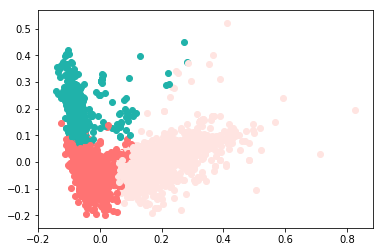

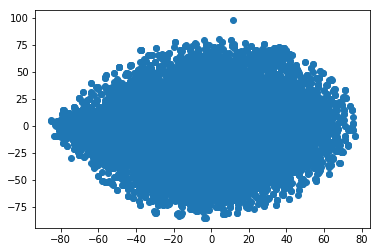

In [21]:
num_clusters = 3
num_seeds = 10
max_iterations = 300
labels_color_map = {
    0: '#20b2aa', 1: '#ff7373', 2: '#ffe4e1'}
pca_num_components = 2
tsne_num_components = 2

# texts_list = some array of strings for which TF-IDF is being computed
# calculate tf-idf of texts
# create k-means model with custom config
x_train_corrected = [" ".join(x) for x in x_train]

vectorizer=TfidfVectorizer(min_df=1,max_df=0.5,stop_words='english', decode_error='ignore')
tf_idf_matrix = vectorizer.fit_transform(x_train_corrected)
clustering_model = KMeans(
    n_clusters=num_clusters,
    max_iter=max_iterations,
    precompute_distances="auto",
    n_jobs=-1
)



labels = clustering_model.fit_predict(tf_idf_matrix)
# print labels

X = tf_idf_matrix.todense()

# ----------------------------------------------------------------------------------------------------------------------

reduced_data = PCA(n_components=pca_num_components).fit_transform(X)
print(reduced_data)

fig, ax = plt.subplots()
for index, instance in enumerate(reduced_data):
    # print instance, index, labels[index]
    pca_comp_1, pca_comp_2 = reduced_data[index]
    color = labels_color_map[labels[index]]
    ax.scatter(pca_comp_1, pca_comp_2, c=color)
plt.show()



# t-SNE plot
embeddings = TSNE(n_components=tsne_num_components)
Y = embeddings.fit_transform(X)
plt.scatter(Y[:, 0], Y[:, 1], cmap=plt.cm.Spectral)
plt.show()